<a href="https://colab.research.google.com/github/Mach-web/Machine_learning/blob/master/decision_forests/tf_decision_trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import necessary modules

In [1]:
!pip install tensorflow_decision_forests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 23.1 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found exist

In [2]:
pip install wurlitzer

In [3]:
import tensorflow_decision_forests as tfdf

In [4]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tf_keras
import matplotlib.pyplot as plt
import math
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [5]:
# print decision_forests version
tfdf.__version__

'1.9.0'

#### Train a random forest model using penguins dataset

In [6]:
# Download the dataset
!wget -q https://storage.googleapis.com/download.tensorflow.org/data/palmer_penguins/penguins.csv -O /tmp/penguins.csv

In [7]:
penguins = pd.read_csv("/tmp/penguins.csv")
penguins.tail(5)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009
343,Chinstrap,Dream,50.2,18.7,198.0,3775.0,female,2009


#### Some data preprocessing

In [8]:
# view unique counts in species column
penguins['species'].value_counts()

Adelie       152
Gentoo       124
Chinstrap     68
Name: species, dtype: int64

In [9]:
classes = penguins['species'].unique().tolist()
print('The label names are: ', classes)
print('There indices are: ', classes.index)

The label names are:  ['Adelie', 'Gentoo', 'Chinstrap']
There indices are:  <built-in method index of list object at 0x7a70d33d0140>


In [10]:
# map the indices to species
penguins['species'] = penguins['species'].map(classes.index)
penguins.tail(5)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
339,2,Dream,55.8,19.8,207.0,4000.0,male,2009
340,2,Dream,43.5,18.1,202.0,3400.0,female,2009
341,2,Dream,49.6,18.2,193.0,3775.0,male,2009
342,2,Dream,50.8,19.0,210.0,4100.0,male,2009
343,2,Dream,50.2,18.7,198.0,3775.0,female,2009


In [11]:
penguins['island'].nunique()

3

In [12]:
penguins['island'].value_counts()

Biscoe       168
Dream        124
Torgersen     52
Name: island, dtype: int64

#### Split dataset

In [13]:
np.random.permutation(5)

array([4, 0, 1, 3, 2])

In [14]:
# randomize penguins dataset
random_penguins = penguins.reindex(np.random.permutation(len(penguins)))
random_penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
211,1,Biscoe,50.4,15.3,224.0,5550.0,male,2008
256,1,Biscoe,47.3,13.8,216.0,4725.0,NaN,2009
7,0,Torgersen,39.2,19.6,195.0,4675.0,male,2007
330,2,Dream,42.5,17.3,187.0,3350.0,female,2009
197,1,Biscoe,43.6,13.9,217.0,4900.0,female,2008


In [15]:
def split_dataset(dataset, test_ratio = .3):
    split_size = int(test_ratio * len(dataset))
    return dataset[split_size:], dataset[:split_size]
train_penguins_pd, test_penguins_pd = split_dataset(random_penguins)
print("{} examples in train set, {} examples in test set".format(len(train_penguins_pd), len(test_penguins_pd)))

241 examples in train set, 103 examples in test set


#### convert pandas dataframe to tensorflow datasets

In [16]:
label = "species"
train_penguins = tfdf.keras.pd_dataframe_to_tf_dataset(train_penguins_pd, label = label)
test_penguins = tfdf.keras.pd_dataframe_to_tf_dataset(test_penguins_pd, label = label)
train_penguins

<_PrefetchDataset element_spec=({'island': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'bill_length_mm': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'bill_depth_mm': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'flipper_length_mm': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'body_mass_g': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'sex': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'year': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

#### Train the random forest model

In [17]:
# define the model
model_1 = tfdf.keras.RandomForestModel(verbose = 0,
        compute_oob_variable_importances = True)
model_1.fit(train_penguins)

#### Remarks
No input features are specified. Therefore, all the columns will be used as input features except for the label.

The feature used by the model are shown in the training logs and in the model.summary().

DFs consume natively numerical, categorical, categorical-set features and missing-values. Numerical features do not need to be normalized.

Categorical string values do not need to be encoded in a dictionary.

No training hyper-parameters are specified. Therefore the default hyper-parameters will be used. Default hyper-parameters provide reasonable results in most situations.

Calling compile on the model before the fit is optional. Compile can be used to provide extra evaluation metrics.

Training algorithms do not need validation datasets. If a validation dataset is provided, it will only be used to show metrics.

Tweak the verbose argument to RandomForestModel to control the amount of displayed training logs. Set verbose=0 to hide most of the logs. Set verbose=2 to show all the logs.

Reference: https://www.tensorflow.org/decision_forests/tutorials/beginner_colab

#### Evaluate the model

In [18]:
model_1.compile(metrics = ["accuracy"])
evaluation = model_1.evaluate(test_penguins, return_dict = True)

for name, value in evaluation.items():
    print("{} : {}".format(name, value))

1/1 [==============================] - 6s 6s/step - loss: 0.0000e+00 - accuracy: 0.9515
loss : 0.0
accuracy : 0.9514563083648682


#### Save the model to prepare for tensorflow serving

In [19]:
model_1.save("/tmp/penguins_saved_model")

#### Plot model

In [20]:
tfdf.model_plotter.plot_model_in_colab(model_1, tree_idx = 0, max_depth = 3)

#### Model summary

In [21]:
model_1.summary()

Model: "random_forest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (7):
	bill_depth_mm
	bill_length_mm
	body_mass_g
	flipper_length_mm
	island
	sex
	year

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1. "flipper_length_mm"  0.450343 ################
    2.    "bill_length_mm"  0.448949 ###############
    3.     "bill_depth_mm"  0.313851 #####
    4.            "island"  0.305526 ####
    5.       "body_mass_g"  0.283242 ##
    6.               "sex"  0.247310 
    7.              "year"  0.247120 

Variable Importance: MEAN_DECREASE_IN_ACCURACY:
    1.    "bill_length_mm"  0.153527 ################
    2.     "bill_depth_mm"  0.008299 #
    3.    

#### Use make_inspector to make summary programmatically

In [22]:
model_1.make_inspector().features()

["bill_depth_mm" (1; #1),
 "bill_length_mm" (1; #2),
 "body_mass_g" (1; #3),
 "flipper_length_mm" (1; #4),
 "island" (4; #5),
 "sex" (4; #6),
 "year" (1; #7)]

In [23]:
model_1.make_inspector().variable_importances()

{'INV_MEAN_MIN_DEPTH': [("flipper_length_mm" (1; #4), 0.4503427771376201),
  ("bill_length_mm" (1; #2), 0.4489485943103817),
  ("bill_depth_mm" (1; #1), 0.3138505971754585),
  ("island" (4; #5), 0.3055262151669473),
  ("body_mass_g" (1; #3), 0.28324169125283305),
  ("sex" (4; #6), 0.24731021658571764),
  ("year" (1; #7), 0.2471199715755803)],
 'MEAN_DECREASE_IN_AUC_2_VS_OTHERS': [("bill_depth_mm" (1; #1),
   0.0007541478129720058),
  ("island" (4; #5), 0.0004901960784320369),
  ("flipper_length_mm" (1; #4), 0.00015082956259493407),
  ("bill_length_mm" (1; #2), 8.881784197001252e-16),
  ("body_mass_g" (1; #3), 6.661338147750939e-16),
  ("sex" (4; #6), 0.0),
  ("year" (1; #7), 0.0)],
 'MEAN_DECREASE_IN_AP_1_VS_OTHERS': [("bill_length_mm" (1; #2),
   0.06951164789553799),
  ("flipper_length_mm" (1; #4), 0.010699501623574026),
  ("island" (4; #5), 0.006232515986111187),
  ("bill_depth_mm" (1; #1), 0.0038873394961267405),
  ("sex" (4; #6), 0.001538819996749874),
  ("year" (1; #7), 0.0),
  (

#### Check model self evaluation on train dataset

In [24]:
model_1.make_inspector().evaluation()

Evaluation(num_examples=241, accuracy=0.966804979253112, loss=0.08924125355989111, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)

### Plot the training logs

In [25]:
model_1.make_inspector().training_logs()

[TrainLog(num_trees=1, evaluation=Evaluation(num_examples=86, accuracy=0.9651162790697675, loss=1.2573366830515307, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=11, evaluation=Evaluation(num_examples=240, accuracy=0.9666666666666667, loss=0.78293465860188, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=21, evaluation=Evaluation(num_examples=241, accuracy=0.966804979253112, loss=0.5047740402681699, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=31, evaluation=Evaluation(num_examples=241, accuracy=0.966804979253112, loss=0.3730438707002218, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=41, evaluation=Evaluation(num_examples=241, accuracy=0.9626556016597511, loss=0.3717523558505838, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=51, evaluation=Evaluation(num_examples=241, accuracy=0.9626556016597511, loss=0.2353098184735943, rmse=None, nd

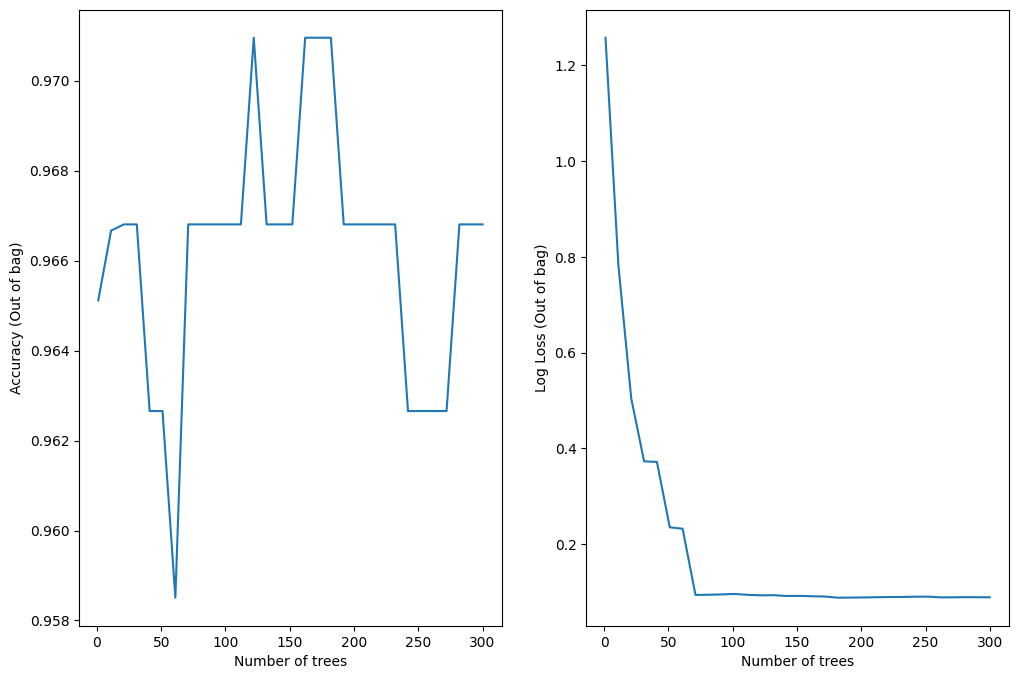

In [26]:
# let's now plots
logs = model_1.make_inspector().training_logs()

plt.figure(figsize = (12,8))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (Out of bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Log Loss (Out of bag)")

plt.show()

#### Use tensorboard to make visualisations

In [27]:
# This cell start TensorBoard that can be slow.
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Google internal version
# %load_ext google3.learning.brain.tensorboard.notebook.extension

In [28]:
# clear existing results if any
!rm -rf "/tmp/tensorboard_logs"

In [29]:
# export metadata to tensorboard
model_1.make_inspector().export_to_tensorboard("/tmp/tensorboard_logs")

In [30]:
#start a tensorboard instance
# %tensorboard --logdir "/tmp/tensorboard_logs"

### Train with a different algorithm

In [31]:
# view all models
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

##### Use built in help function to get description of learning algorithm and hyperparameters

In [32]:
# this works anywhere
help(tfdf.keras.RandomForestModel)

# works in notebooks
tfdf.keras.RandomForestModel?

Help on class RandomForestModel in module tensorflow_decision_forests.keras:

class RandomForestModel(tensorflow_decision_forests.keras.wrappers.RandomForestModel)
 |  RandomForestModel(*args, **kwargs)
 |  
 |  Method resolution order:
 |      RandomForestModel
 |      tensorflow_decision_forests.keras.wrappers.RandomForestModel
 |      tensorflow_decision_forests.keras.core.CoreModel
 |      tensorflow_decision_forests.keras.core_inference.InferenceCoreModel
 |      tf_keras.src.engine.training.Model
 |      tf_keras.src.engine.base_layer.Layer
 |      tensorflow.python.module.module.Module
 |      tensorflow.python.trackable.autotrackable.AutoTrackable
 |      tensorflow.python.trackable.base.Trackable
 |      tf_keras.src.utils.version_utils.LayerVersionSelector
 |      tf_keras.src.utils.version_utils.ModelVersionSelector
 |      builtins.object
 |  
 |  Data and other attributes defined here:
 |  
 |  __annotations__ = {}
 |  
 |  -------------------------------------------------

#### Using a subset of the features

In [34]:
feature_1 = tfdf.keras.FeatureUsage(name = "bill_length_mm")
feature_2 = tfdf.keras.FeatureUsage(name = "island")

all_features = [feature_1, feature_2]

model_2 = tfdf.keras.GradientBoostedTreesModel(
    features=all_features, exclude_non_specified_features=True)

model_2.compile(metrics = ["accuracy"])
model_2.fit(train_penguins, validation_data = test_penguins)

print(model_2.evaluate(test_penguins, return_dict = True))

Use /tmp/tmp6c_kceyn as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.211942. Found 241 examples.
Reading validation dataset...
Num validation examples: tf.Tensor(103, shape=(), dtype=int32)
Validation dataset read in 0:00:00.601661. Found 103 examples.
Training model...
Model trained in 0:00:00.126363
Compiling model...
Model compiled.
1/1 [==============================] - 1s 569ms/step - loss: 0.0000e+00 - accuracy: 0.9515
{'loss': 0.0, 'accuracy': 0.9514563083648682}


#### How to treat a numerical feature as categorical

In [38]:


feature_1 = tfdf.keras.FeatureUsage(name = "year", semantic = tfdf.keras.FeatureSemantic.CATEGORICAL)
feature_2 = tfdf.keras.FeatureUsage(name = "bill_length_mm")
feature_3 = tfdf.keras.FeatureUsage(name = "sex")

all_features = [feature_1, feature_2, feature_3]

model_3 = tfdf.keras.GradientBoostedTreesModel(
    features = all_features, exclude_non_specified_features = True)
model_3.compile(metrics = ["accuracy"])
model_3.fit(train_penguins, validation_data = test_penguins)

print(model_3.evaluate(test_penguins, return_dict = True))

Use /tmp/tmp525ybkyp as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.182819. Found 241 examples.
Reading validation dataset...
Num validation examples: tf.Tensor(103, shape=(), dtype=int32)
Validation dataset read in 0:00:00.188025. Found 103 examples.
Training model...
Model trained in 0:00:00.112004
Compiling model...
Model compiled.


1/1 [==============================] - 0s 162ms/step - loss: 0.0000e+00 - accuracy: 0.8155
{'loss': 0.0, 'accuracy': 0.8155339956283569}
